In [58]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

In [59]:
def calculate_recall(pairwise_df, review_df, similarity_threshold):

    if pairwise_df.empty:
        return 0

    # Filter pairwise_df based on similarity threshold
    relevant_matches = pairwise_df[pairwise_df['similarity'] >= similarity_threshold]

    # Calculate recall
    total_points_human_review = len(review_df)  
    recall = len(relevant_matches) / total_points_human_review if total_points_human_review > 0 else 0

    return recall

In [60]:
# Dictionary to store data for each parent folder
bigger_parent_folder = "./extracted"

extracted_data = {}

# Walk through only directories directly under the bigger parent folder
for parent_folder in os.listdir(bigger_parent_folder):
    parent_folder_path = os.path.join(bigger_parent_folder, parent_folder)
    
    # Ensure we're only processing directories
    if os.path.isdir(parent_folder_path):
        # Initialize dictionary entry for each parent folder
        extracted_data[parent_folder] = {'pairwise': {}, 'summarised': {}}
        
        # Check if 'pairwise' folder exists in the current parent folder
        pairwise_folder_path = os.path.join(parent_folder_path, 'pairwise')
        if os.path.isdir(pairwise_folder_path):
            for filename in os.listdir(pairwise_folder_path):
                if filename.endswith('.json'):
                    filepath = os.path.join(pairwise_folder_path, filename)
                    with open(filepath) as f:
                        data = json.load(f)
                        df = pd.DataFrame(data).T
                        extracted_data[parent_folder]['pairwise'][filename.replace('.json', '')] = df

        
        # Check if 'summarised' folder exists in the current parent folder
        summarised_folder_path = os.path.join(parent_folder_path, 'summarised')
        if os.path.isdir(summarised_folder_path):
            for filename in os.listdir(summarised_folder_path):
                if filename.endswith('.json'):
                    filepath = os.path.join(summarised_folder_path, filename)
                    with open(filepath) as f:
                        data = json.load(f)
                        df = pd.DataFrame(data).T
                        extracted_data[parent_folder]['summarised'][filename.replace('.json', '')] = df

# Output the collected data for each parent folder
extracted_data['exploring_extreme_parameter_compression_for_pre-trained_language_models']['summarised']['review1']


,summary,verbatim
1,The model size reported does not include the e...,The authors do not include embedding layer and...
2,Limited experimental comparison with other rel...,"The authors name a lot of related works, but c..."


In [61]:
def all_pairwise_recall(extracted_data, similarity_threshold):
    pairwise_recall = {}

    for paper in extracted_data:
        pairwise_dfs = extracted_data[paper]['pairwise']
        summarised_dfs = extracted_data[paper]['summarised']
        pairwise_recall[paper] = {}

        for pair in pairwise_dfs:
            pair_human_review = pair.split('-')[0]
            for summary in summarised_dfs:
                if (summary == pair_human_review):
                    recall = calculate_recall(pairwise_dfs[pair], summarised_dfs[summary], similarity_threshold)
                    pairwise_recall[paper][pair] = recall

    return pairwise_recall

def plot_average_recall(data):
    # Initialize variables to calculate averages for each model
    gpt4_recalls = []
    gemini_pro_recalls = []

    # Extract recall values by model
    for _, reviews in data.items():
        for review, recall in reviews.items():
            if 'gpt4' in review:
                gpt4_recalls.append(recall)
            elif 'gemini_pro' in review:
                gemini_pro_recalls.append(recall)

    # Calculate average recall for each model and convert to percentage
    avg_gpt4_recall = (sum(gpt4_recalls) / len(gpt4_recalls) * 100) if gpt4_recalls else 0
    avg_gemini_pro_recall = (sum(gemini_pro_recalls) / len(gemini_pro_recalls) * 100) if gemini_pro_recalls else 0

    # Plotting
    models = ['GPT-4', 'Gemini Pro']
    avg_recalls = [avg_gpt4_recall, avg_gemini_pro_recall]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, avg_recalls, color=['skyblue', 'salmon'])
    plt.ylabel("Average Recall (%)")
    plt.title("Average Recall by AI Model")
    plt.ylim(0, 100)  # Set y-axis to percentage range

    # Display exact values above bars
    for bar, value in zip(bars, avg_recalls):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{value:.2f}%', 
                 ha='center', va='bottom', fontsize=10)

    plt.show()

In [62]:
all_recall = all_pairwise_recall(extracted_data, 0.7)

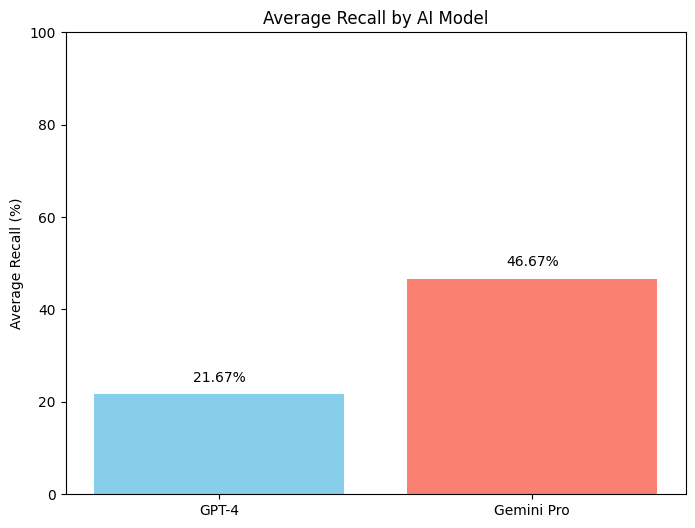

In [63]:
plot_average_recall(all_recall)